# Tweet Sentiment Analysis

Little experiment to classify tweets using the Stochastic Gradient Descent (SGD) linear classifier from sklearn.

In [36]:
import csv
import html
import numpy as np
import preprocessor
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

## Preparing data

Download Sentiment140 dataset from Kaggle:

https://www.kaggle.com/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv

Unzip the data:
```
$ unzip training.1600000.processed.noemoticon.csv.zip
```

Too much to crunch all on a laptop, so let's take a random subset of tweets:
```
$ sort -R training.1600000.processed.noemoticon.csv | head -n 20000 > tweet-data-random.csv
```

We can now work with `tweet-data-random.csv`.

In [29]:
# load texts and sentiments in ordered lists

texts = []
sentiments = []


def clean_text(text):
    """
    Clean input text with tweet-preprocessor and html.unescape
    This will remove emojis, urls, hashtags, @ mentions and html special char encoding
    """
    text = preprocessor.clean(text)
    text = html.unescape(text)
    return text


csv_fields = ["sentiment", "id", "date", "flag", "user", "text"]
with open("data/tweet-data-random.csv") as csvfile:
    tweet_reader = csv.DictReader(csvfile, delimiter=",", quotechar='"', fieldnames=csv_fields)
    for tweet in tweet_reader:
        sentiments.append(tweet["sentiment"])
        texts.append(clean_text(tweet["text"]))

In [103]:
# get labels from sentiments
# 'sentiment = 0' is negative and will stay 'labels[i] = 0'
# 'sentiment = 4' is positive and will become 'labels[i] = 1'

labels = np.array(list(map(lambda x: 0 if x == '0' else 1, sentiments)))

# get feature from texts
# CountVectorizer implements tokenization and counting of input corpus (i.e. does bag of words)
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(texts)

We now have a numpy array of `labels` and an associated features matrix with `features.toarray()`.

We will use some of these for training and the rest for testing:

In [31]:
split_index = int(0.90 * len(labels))

train_labels, test_labels = np.split(labels, [split_index])
train_features, test_features = np.split(features.toarray(), [split_index])

## Hyperparameter optimization

We use the Stochastic Gradient Descent classifier (`SGDClassifier`). This uses the derivative of the objective function J to determine the direction in which to update `theta` to minimize J. This way, every update we end up with a smaller `J(theta)`.

The hyperparameter `alpha` is the regularization parameter. In the objective function, `alpha` balances between average hinge loss and the regularization function R. The higher `alpha`, the higher R and the larger the margins around the decision boundary. The role of R is to prever overfitting `theta` to training data.

We loop through many values of `alpha` to find the value that maximizes accuracy. We use cross-validation here with `cv = 5`. This means we split the training data into five sets, and use four of them for training and one for validation, iterating five times such that every set is used for validation once, and then taking the mean.

In [95]:
def plot_alphas(alpha, val_scores, alpha_star):
    """
    Plots alphas and accuracies
    """
    plt.plot(alpha, val_scores)
    plt.axvline(x=alpha_star, color="orange", linestyle="dashed")
    plt.xlim(0, alpha[-1])
    plt.xlabel('alpha')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.grid(True)
    plt.show()


def test_alphas():
    """
    Loop through some alphas and return tuple (alphas, accuracies)
    """ 
    alpha = np.arange(0.0003, 0.0008, 0.00005)
    val_scores = np.zeros((len(alpha), 1))

    for i in range(len(alpha)):
        model = SGDClassifier(alpha=alpha[i])
        score = cross_val_score(model, train_features, train_labels, cv=5)
        val_scores[i] = score.mean()
    
    return alpha, val_scores

        
def get_alpha_star(alpha, val_scores):
    """
    Returns best alpha
    """
    alpha_star_index = np.argmax(val_scores)
    alpha_star = alpha[alpha_star_index]
    return alpha_star

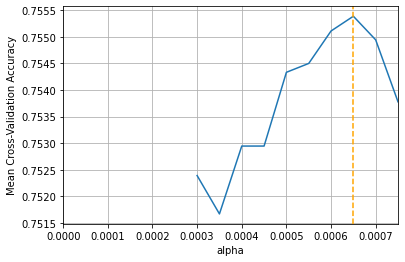

Optimal alpha = 0.0006500000000000002


In [96]:
alphas, val_scores = test_alphas()
alpha_star = get_alpha_star(alphas, val_scores)
plot_alphas(alphas, val_scores, alpha_star)
print(f"Optimal alpha = {alpha_star}")

## Training and Testing

In [97]:
model = SGDClassifier(alpha=alpha_star)
model_trained = model.fit(train_features, train_labels)
print('Accuracy:', model_trained.score(test_features, test_labels))

Accuracy: 0.763


## Explore

### Classify some tweets
Let's try to classify some new tweets. These don't show up in either the training or testing data used so far.

In [182]:
some_tweets = [
    "im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!",
    "@hawaii808shellz hAhAHA!! omG! we wer bOth laughiN off d hOOk!  cuz das hOW we roLLL...ryt sheLdawg?",
    "happy to spend time with the family. ",
    "Aw i'm holding my new puppy. Well He's not mine but He's a cutie. ",
    "spring break in plain city... it's snowing ",
    "about to file taxes ",
    "im sad now  Miss.Lilly",
    "Meh... Almost Lover is the exception... this track gets me depressed every time. ",
    "this week is not going as i had hoped ",
]

clean_some_tweets = list(map(clean_text, more_tweets))
some_features = vectorizer.transform(clean_more_tweets)
some_classified_tweets = model_trained.predict(more_features)

In [184]:
for i in range(len(some_tweets)):
    sentiment = "positive" if some_classified_tweets[i] else "negative"
    print(i, sentiment, some_tweets[i])

0 positive im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
1 positive @hawaii808shellz hAhAHA!! omG! we wer bOth laughiN off d hOOk!  cuz das hOW we roLLL...ryt sheLdawg?
2 positive happy to spend time with the family. 
3 negative Aw i'm holding my new puppy. Well He's not mine but He's a cutie. 
4 positive spring break in plain city... it's snowing 
5 negative about to file taxes 
6 negative im sad now  Miss.Lilly
7 negative Meh... Almost Lover is the exception... this track gets me depressed every time. 
8 negative this week is not going as i had hoped 


Nice! It looks like only one tweet is misclassified.

### Most explanatory unigrams

In [179]:
sorted_coef = model_trained.coef_[0].argsort()


def get_word_by_index(index, vocabulary):
    """
    Returns a word given it's index in the CountVectorizer vocabulary
    """
    for key, value in vocabulary.items():
        if value == index:
            return key

#### Top 5 positive unigrams

In [180]:
for index in list(reversed(sorted_coef))[:5]:
    word = get_word_by_index(index, vectorizer.vocabulary_)
    print(word)

yay
thanks
great
smile
welcome


#### Top 5 negative unigrams

In [181]:
for index in sorted_coef[:5]:
    word = get_word_by_index(index, vectorizer.vocabulary_)
    print(word)

sad
miss
sick
sucks
missing
